# Object detection



In [ ]:
!pip install pycocotools

In [ ]:
import os
!mkdir detection
os.chdir("/content/detection")

In [ ]:
%%bash
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0
cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be37608 version check against PyTorch's CUDA version


In [ ]:
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd
import os
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import torchvision.utils
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torchvision
from PIL import ImageDraw, Image
from google.colab import drive

In [ ]:
drive.mount("/content/drive")
data_path = "/content/drive/My Drive/Colab Notebooks/data/"
train_path = "/content/drive/My Drive/Colab Notebooks/data/train.jsonl"
valid_path = "/content/drive/My Drive/Colab Notebooks/data/dev.jsonl"
test_path = "/content/drive/My Drive/Colab Notebooks/data/test.jsonl"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


device(type='cuda')

In [ ]:
preprocess = T.Compose([
  T.Resize((256,256)),
  T.ToTensor()
])
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

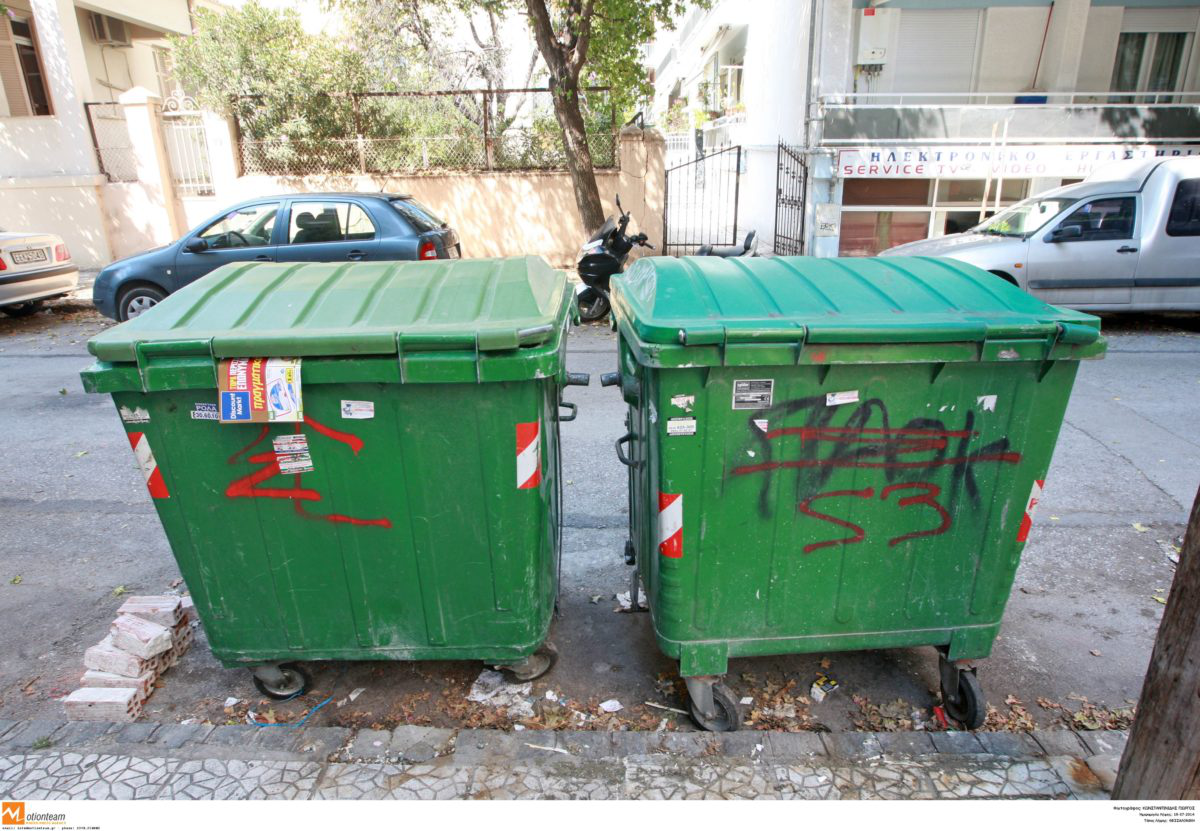

In [ ]:
from PIL import ImageDraw

path = "/content/drive/MyDrive/Colab Notebooks/Recycle/bins/"
# img_path = path + "recycle/recycle_4.jpg"
img_path = path + "garbage/garbage_9.jpg"

img = Image.open(img_path).convert('RGB')
img

In [ ]:
model.eval()
with torch.no_grad():
  img = preprocess(img)
  label = "Garbage Bin"
  pred = model([img])
  img = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
  print(pred)

[{'boxes': tensor([[ 19.3041,  58.7457,  99.5399,  98.5405],
        [  0.0000,  70.8273,  17.7887,  96.7003],
        [185.5525,  48.2164, 255.2607,  98.5606],
        [ 19.7408,  81.2703, 122.3123, 206.9846],
        [189.5055,  49.8202, 255.5180,  97.0056],
        [122.9799,  71.3118, 138.8682, 101.1681],
        [124.2781,  66.4408, 237.0491, 221.4059],
        [129.9274,  76.2980, 235.5134, 214.9109],
        [174.1977,  32.1280, 253.2427,  85.6231],
        [ 11.0486,  72.1703, 127.9662, 199.4159],
        [122.0507,  68.5256, 136.1691, 100.1646],
        [129.9572,  73.6956, 234.8580, 226.5202],
        [ 15.0006,  66.6410, 127.3626, 213.4149],
        [130.4981,  81.5763, 237.7395, 226.5471],
        [ 16.9492,  71.1256, 124.3053, 216.0999],
        [131.9641,  73.0705, 235.0625, 221.2859],
        [ 62.1179,  64.3279,  73.2049,  74.2810],
        [  0.0000,  71.0501,  17.6924,  98.3776],
        [132.4848,  71.5974, 139.5430,  82.2505],
        [124.3842,  70.5236, 237.9061, 

In [ ]:
labels = pd.read_csv("/content/coco_2017_labels.csv")

In [ ]:
  from PIL import ImageFont
  for element in range(len(pred[0]["boxes"])):
        boxes = pred[0]["boxes"][element].cpu().numpy()
        score = np.round(pred[0]["scores"][element].cpu().numpy(), decimals= 4)
        if score > 0.3 and score<0.7:
          draw = ImageDraw.Draw(img)
          label = pred[0]["labels"][element].cpu().numpy()
          label = labels['label'].iloc[label]
          print(label)
          if (label != 'car' and label != 'truck' and label != 'person'):
            draw.rectangle([(boxes[0], boxes[1]), (boxes[0]+boxes[3], boxes[1] +boxes[2])], outline ='red')
            draw.text((boxes[0], boxes[1]), text = "Garbage Bin", fill=(0,0,0))

parkingmeter
car
person
truck


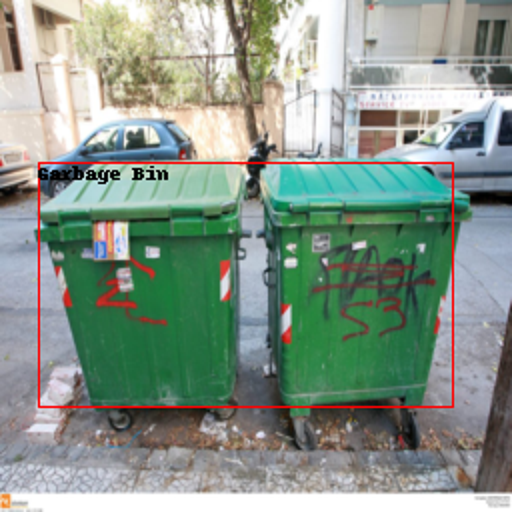

In [ ]:
img.resize((512,512))

# Classification of bins

In [ ]:
import torch
from torch import nn
import torchvision
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from torch.utils.data import Dataset, DataLoader
import cv2
import torchtext
from torchvision import transforms
from PIL import Image
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, file_path):
    self.file = pd.read_csv(file_path, header=None)
  
  def __len__(self):
    return len(self.file)
  
  def __getitem__(self,idx):
    img = Image.open(self.file.iloc[idx][0]).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor()
    ])
    img = preprocess(img)
    sample = {}
    label = 0 if ('garbage' in self.file.iloc[idx][0]) else 1
    sample = {"img":img, "label":label}
    return sample

In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/Recycle/bins/bin_file.csv"
data = ImageDataset(file_path)
d = pd.read_csv(file_path)

54

In [ ]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet152', pretrained=True)
for p in model.parameters():
    p.requires_grad = False
model = nn.Sequential(
          model, 
          nn.Linear(1000,500),
          nn.Linear(500,2))
model.to(device)
print("Model ok!!!")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Model ok!!!


In [ ]:
train_imgs = ImageDataset(file_path)

train_loader = DataLoader(train_imgs, batch_size=32, shuffle=True)

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


num_epochs = 20
train_loss = []
val_loss = []
running_loss = 0.0
val_running_loss = 0.0

step = 0
val_step = 0
model.train()
for epoch in range(num_epochs):
  running_loss = 0.0
  val_running_loss = 0.0
  step = 0
  val_step = 0
  print("---------------------------------------------------------------------")
  for i, batches in enumerate(train_loader):
    batch = batches['img']
    labels = batches['label']
 
    optimizer.zero_grad()
    batch = batch.cuda().float()
    labels = labels.cuda().float()
 
    outputs = model(batch)
    loss = criterion(outputs.squeeze(1), labels.long())
    loss.backward()
    optimizer.step()
    step +=1
    running_loss += loss.item()
  running_loss /= step
  print(f"Epoch: {epoch}, Train Loss: {running_loss}")
  print("---------------------------------------------------------------------")             
print("Finish training.")
state_dict = {'model_state_dict':model.state_dict()}
torch.save(state_dict, "/content/drive/MyDrive/Colab Notebooks/Recycle/bins/model_bins.pt")

---------------------------------------------------------------------
Epoch: 0, Train Loss: 0.7606978118419647
---------------------------------------------------------------------
---------------------------------------------------------------------
Epoch: 1, Train Loss: 0.6409007608890533
---------------------------------------------------------------------
---------------------------------------------------------------------
Epoch: 2, Train Loss: 0.4238996058702469
---------------------------------------------------------------------
---------------------------------------------------------------------
Epoch: 3, Train Loss: 0.30621273815631866
---------------------------------------------------------------------
---------------------------------------------------------------------
Epoch: 4, Train Loss: 0.1871093362569809
---------------------------------------------------------------------
---------------------------------------------------------------------
Epoch: 5, Train Loss: 0.

  Recycle Bin


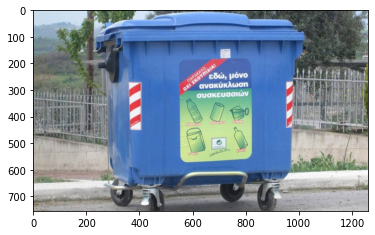

In [ ]:
state_dict = torch.load("/content/drive/MyDrive/Colab Notebooks/Recycle/bins/model_bins.pt", map_location=device)
model.load_state_dict(state_dict['model_state_dict'])

model.eval()
labels = {0:'Garbage Bin',1:'Recycle Bin'}
preprocess = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])
path = "/content/drive/MyDrive/Colab Notebooks/Recycle/bins/kados-patra2.jpg"
img = Image.open(path)
img = preprocess(img)
with torch.no_grad():
  img = img.unsqueeze(0).cuda()
  pred = model(img)
  img = Image.open(path)
  plt.imshow(img)
  print(' ',labels[torch.argmax(pred).item()])

# Material Classification

In [ ]:
import torch
from torch import nn
import torchvision
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from torch.utils.data import Dataset, DataLoader
import cv2
import torchtext
from torchvision import transforms
from PIL import Image
from sklearn import metrics
from sklearn.metrics import accuracy_score
import os

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Recycle/dataset-resized/'

In [ ]:
imgs = []
labels = []
_,dirs,_ = os.walk(path).__next__()

for dir in dirs:
  folder_path = path+dir
  for _,_,files in  os.walk(folder_path):
    for f in files:
      imgs.append(folder_path+'/'+f)
      label = 0
      if ('paper' in f):
        label=0
      elif ('trash' in f):
        label=1
      elif ('plastic' in f):
        label=2
      elif ('metall' in f ):
        label=3
      elif ('glass' in f ):
        label=4
      else:
        label=5
      labels.append(label)
dataset = {'img':imgs, 'label':labels}
dataset['img'][0], len(imgs), len(labels)

('/content/drive/MyDrive/Colab Notebooks/Recycle/dataset-resized/paper/paper1.jpg',
 2527,
 2527)

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, data):
    self.data = data
  
  def __len__(self):
    return len(self.data['img'])
  
  def __getitem__(self,idx):
    img = Image.open(self.data['img'][idx]).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor()
    ])
    img = preprocess(img)
    sample = {}
    label = self.data['label'][idx]
    sample = {"img":img, "label":label}
    return sample

In [ ]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet152', pretrained=True)
for p in model.parameters():
    p.requires_grad = False
model = nn.Sequential(
          model, 
          nn.Linear(1000,500),
          nn.Linear(500,6))
model.to(device)
print("Model ok!!!")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Model ok!!!


In [ ]:
train_imgs = ImageDataset(dataset)

train_loader = DataLoader(train_imgs, batch_size=32, shuffle=True)

In [ ]:
criterion = nn.CrossEntropyLoss()


optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


num_epochs = 20
train_loss = []
val_loss = []
running_loss = 0.0
val_running_loss = 0.0

step = 0
val_step = 0
model.train()
for epoch in range(num_epochs):
  running_loss = 0.0
  val_running_loss = 0.0
  step = 0
  val_step = 0
  print("---------------------------------------------------------------------")
  for i, batches in enumerate(train_loader):
    batch = batches['img']
    labels = batches['label']
 
    optimizer.zero_grad()
    batch = batch.cuda().float()
    labels = labels.cuda().float()
 
    outputs = model(batch)
    loss = criterion(outputs.squeeze(1), labels.long())
    loss.backward()
    optimizer.step()
    step +=1
    running_loss += loss.item()
  running_loss /= step
  print(f"Epoch: {epoch}, Train Loss: {running_loss}")
  print("---------------------------------------------------------------------")             
print("Finish training.")
state_dict = {'model_state_dict':model.state_dict()}
torch.save(state_dict, path+"model_materials.pt")

---------------------------------------------------------------------
Epoch: 0, Train Loss: 0.874808478958999
---------------------------------------------------------------------
---------------------------------------------------------------------
Epoch: 1, Train Loss: 0.5400129113393494
---------------------------------------------------------------------
---------------------------------------------------------------------
Epoch: 2, Train Loss: 0.4839390984064416
---------------------------------------------------------------------
---------------------------------------------------------------------
Epoch: 3, Train Loss: 0.44678971020481256
---------------------------------------------------------------------
---------------------------------------------------------------------
Epoch: 4, Train Loss: 0.4283065839281565
---------------------------------------------------------------------
---------------------------------------------------------------------
Epoch: 5, Train Loss: 0.4

  cardboard


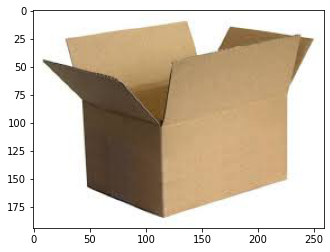

In [ ]:
state_dict = torch.load("/content/drive/MyDrive/Colab Notebooks/Recycle/dataset-resized/model_materials.pt", map_location=device)
model.load_state_dict(state_dict['model_state_dict'])
labels = ['paper','trash','plastic','metall','glass','cardboard']
model.eval()
preprocess = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])
img = Image.open("/content/drive/MyDrive/Colab Notebooks/Recycle/dataset-resized/cardboard.jpg")
img = preprocess(img)
with torch.no_grad():
  img = img.unsqueeze(0).cuda()
  pred = model(img)
  img = Image.open("/content/drive/MyDrive/Colab Notebooks/Recycle/dataset-resized/cardboard.jpg")
  plt.imshow(img)
  print(' ',labels[torch.argmax(pred).item()])